<a href="https://colab.research.google.com/github/saotomryo/Use_VisionTransFormer/blob/main/Vision__Transfomer_with_Cross_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## トランスフォーマー等のインストールコンポーネントのインストール

In [1]:
!pip install transformers
!pip list | grep transformers
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

     |████████████████████████████████| 2.9 MB 8.4 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 3.3 MB 55.6 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 636 kB 52.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
transformers                  4.11.3
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-ey872js8
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-ey872js8
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3879 sha256=571e116cfb2a115d14192e2c2cce3d3abaa33e7c7ff09c50dfacf7e1e876db54
  Stored in directory: /tmp/pip-ephem-wheel-cache-nt2fvhto/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully bui

## 利用するパッケージのインポート

In [18]:
from PIL import Image
import os
from glob import glob

import pandas as pd
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from statistics import mean

import warmup_scheduler
from transformers import ViTFeatureExtractor, ViTModel

学習を行う対象フォルダ
へ移動

対象フォルダは以下の形式となっていることとする

全体のフォルダ

　- ラベル付けを行うフォルダ（フォルダ名を正解ラベルの名前をしてください）

　　　　　- 各画像ファイル


In [3]:
%cd /content/drive/MyDrive/AIQUEST/train_fix

/content/drive/MyDrive/AIQUEST/train_fix


In [4]:
folders = os.listdir("./")
print(folders)

['regular', 'bridge', 'horn', 'potato']


In [5]:
tmp = []

for folder in folders:
    if folder[0] != '.':
        filiename_list = glob('./' + folder + '/*.jpeg')
        print(filiename_list)
        for filename in filiename_list:
            category = folder
            tmp.append([filename,category])

# １レコードがファイルパスとカテゴリー（正解ラベル）になるようにDataFrameにまとめる
handa_df = pd.DataFrame(tmp, columns=['path', 'category'])

# カテゴリーをID（数値）に変換した列を追加する
categories = handa_df['category'].unique().tolist()
handa_df['category_id'] = handa_df['category'].map(lambda x: categories.index(x))


['./regular/regular_000.jpeg', './regular/regular_001.jpeg', './regular/regular_002.jpeg', './regular/regular_003.jpeg', './regular/regular_004.jpeg', './regular/regular_005.jpeg', './regular/regular_006.jpeg', './regular/regular_007.jpeg', './regular/regular_008.jpeg', './regular/regular_009.jpeg', './regular/regular_010.jpeg', './regular/regular_011.jpeg', './regular/regular_012.jpeg', './regular/regular_013.jpeg', './regular/regular_014.jpeg', './regular/regular_015.jpeg', './regular/regular_016.jpeg', './regular/regular_017.jpeg', './regular/regular_018.jpeg', './regular/regular_019.jpeg', './regular/regular_020.jpeg', './regular/regular_021.jpeg', './regular/regular_022.jpeg', './regular/regular_023.jpeg', './regular/regular_024.jpeg', './regular/regular_025.jpeg', './regular/regular_026.jpeg', './regular/regular_027.jpeg', './regular/regular_028.jpeg', './regular/regular_029.jpeg', './regular/regular_030.jpeg', './regular/regular_031.jpeg', './regular/regular_032.jpeg', './regula

In [6]:
# データの前処理及びデータ水増し

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10,10)), # 5度の範囲で画像をランダムに回転
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(224,224),scale=(0.9,0.9),ratio=(1.0,1.0)), # アスペクト比を保って、0.9倍のサイズでランダムに画像を224x224に切り出し
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNetに合わせて画像の標準化
])
val_transform = transforms.Compose([ # 検証データ用の画像の前処理
    transforms.RandomResizedCrop(size=(224,224),scale=(1.0,1.0),ratio=(1.0,1.0)), # アスペクト比を保って画像をリサイズ
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



# データセットを定義する

In [8]:

class HandaData(Dataset):
    def __init__(self, df, phase):
        self.images = []
        self.categories = []

        for row in tqdm(df.itertuples(), total=df.shape[0]):
            path = row.path
            if phase != 'test':
                category = row.category_id
            else:
                category = 0
            image = Image.open(path)

            # 学習用データの定義
            if phase == 'train':

                try:
                    # 学習用の処理を行なったデータ
                    feature_ids = torch.reshape(transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass
            else:

                try:
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.categories[idx]



# モデルのインポート

In [10]:
# 事前学習済みモデルのインポート

# モデル本体
# 順伝播時の出力にAttentionの結果もほしいときはoutput_attentions=Trueを指定する。
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', output_attentions=True)

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

# 入力サイズを事前学習済みモデルのものと変更する場合は以下のコードを利用

In [11]:
# vit_modelの入力サイズをx * xに変更する

#configuration = ViTConfig(image_size = (x,x))

# Initializing a model from the vit-base-patch16-224 style configuration
#vit_model = ViTModel(configuration)

# モデルの定義

In [12]:
# モデルクラスの宣言

class ViTNet(nn.Module):
    def __init__(self, pretrained_vit_model, class_num):
        super(ViTNet, self).__init__()
        self.vit = pretrained_vit_model #学習ずみモデル
        self.fc = nn.Linear(768, class_num)

    def _get_cls_vec(self, states):
        return states['last_hidden_state'][:, 0, :]

    def forward(self, input_ids):
        states = self.vit(input_ids)
        states = self._get_cls_vec(states)
        states = self.fc(states)
        return states

# 今回のデータのカテゴリ（フォルダ数）
CLASS_NUM = len(categories)

# 事前学習済モデルを引数で渡します。
net = ViTNet(vit_model, CLASS_NUM)

# GPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# モデルの初期値を保存する（xxxxに保存するパスを記載してください）
model_path = 'xxxxx'
torch.save(net.state_dict(),model_path)


# 損失関数（スムースクロスエントロピー）の定義

学習する正解ラベルの値を１(100%)とするのではなく、少し減らした値で学習するようにする

In [13]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# 固定パラメータの指定

In [14]:
EPOCHS = 20  # 学習を回す回数
BATCH_SIZE = 32 # 一回に並列で演算する個数
FOLD_NUM = 5 # 交差検証で分割を行う分割数


# 学習用の関数の定義

In [17]:
def train_one(net,train,valid):

    # 結果確認用の配列の定義
    train_losses = []
    val_losses = []
    train_fscores = []
    train_fscores2 = []
    val_fscores = []
    val_fscores２ = []
    train_accuracies = []
    val_accuracies = []

    best_val_fscore = 0

    for epoch in range(EPOCHS):

        # 学習
        train_loss = 0.0
        train_predict = []
        train_answer = []
        train_predict2 = []
        train_answer2 = []
        net.train()
        for batch in train_loader:
            optimizer.zero_grad() # オプティマイザの初期化

            input_ids = batch[0].to(device) # 入力データをGPUに渡す
            y = batch[1].to(device) # 入力データをGPUに渡す
            out = net(input_ids) # 学習データをモデルに投入
            loss = criterion(out, y) # 損失関数を出力
            loss.backward() # 誤差逆伝播の実行
            optimizer.step() # オプティマイザを更新

            # 記録用に出力値を保管
            train_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
            train_answer += y.cpu().detach().numpy().tolist()
            tmp_predict = out.argmax(dim=1).cpu().detach().numpy()
            tmp_predict[tmp_predict > 0] = 1
            train_predict2 += tmp_predict.tolist()
            tmp_answer = y.cpu().detach().numpy()
            tmp_answer[tmp_answer > 0] = 1
            train_answer2 += tmp_answer.tolist()
            train_loss += loss.item()

        # warmupの実装
        scheduler_w.step()

        # エポックごとの損失の合計とF1-scoreを計算する
        train_losses.append(train_loss)
        train_fscore = f1_score(train_answer, train_predict, average='macro')
        train_fscores.append(train_fscore)
        train_fscore2 = f1_score(train_answer2, train_predict2, average='macro')
        train_fscores2.append(train_fscore2)
        train_accuracy = accuracy_score(train_answer, train_predict)
        train_accuracies.append(train_accuracy)

        # 検証
        val_loss = 0.0
        val_predict = []
        val_answer = []
        val_predict2 = []
        val_answer2 = []
        net.eval()

        # 検証用の処理
        for batch in val_loader:
            with torch.no_grad(): # 検証モードとして、学習を行わないことを宣言
                # モデルへデータを投入し、損失関数を出力
                input_ids = batch[0].to(device)
                y = batch[1].to(device)
                out = net(input_ids)
                loss = criterion(out, y)

                # 記録用に出力データを保管
                val_loss += loss.item()
                _, y_pred = torch.max(out, 1)            
                val_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
                tmp_predict = out.argmax(dim=1).cpu().detach().numpy()
                tmp_predict[tmp_predict > 0] = 1
                val_predict2 += tmp_predict.tolist()
                val_answer += y.cpu().detach().numpy().tolist()
                tmp_answer = y.cpu().detach().numpy()
                tmp_answer[tmp_answer > 0] = 1
                val_answer2 += tmp_answer.tolist()

        # エポックごとの損失の合計とF1-scoreを計算する
        val_losses.append(val_loss)
        val_fscore = f1_score(val_answer, val_predict, average='macro')
        val_fscores.append(val_fscore)
        val_fscore2 = f1_score(val_answer2, val_predict2, average='macro')
        val_fscores2.append(val_fscore2)
        val_accuracy = accuracy_score(val_answer, val_predict)
        val_accuracies.append(val_accuracy)

        # 損失関数、および精度の値を出力
        print('epoch', epoch,
            '\ttrain loss', round(train_loss, 4), '\ttrain fscore', round(train_fscore, 4) ,'\ttrain fscore2', round(train_fscore2, 4),'\ttrain accuracy', round(train_accuracy,4),
            '\tval loss', round(val_loss, 4), '\tval fscore', round(val_fscore, 4) , '\tval fscore2', round(val_fscore2, 4) ,'\tval accuracy', round(val_accuracy,4),
            )
        
        
        # 検証データでF scoreの値を更新した時のみベストモデルを更新（過学習対策）
        if val_fscore2 > best_val_fscore:
            best_model = net
            best_train_fscore = train_fscore2
            best_val_fscore = val_fscore2


    return best_model,best_train_fscore,best_val_fscore

# 学習の実行

In [ ]:
# fold毎のモデル、正解率、損失を格納する配列
nets, train_fscores, val_fscores = [], [], []

y = handa_df.category_id

# n_splits分割（ここでは5分割）してCV
kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=2020)

i = 0

for train_idx, valid_idx in kf.split(handa_df,handa_df.category_id):

    # モデルの初期化を毎回実施する
    net = ViTNet(vit_model, CLASS_NUM)

    # GPU使う
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    net.load_state_dict(torch.load('/content/default_model.pth'))

    # まず全パラメータを勾配計算Falseにする
    for param in net.parameters():
        param.requires_grad = False
        #param.requires_grad = True

    # 最終層を勾配計算ありに変更
    for param in net.vit.encoder.layer[11].parameters():
        param.requires_grad = True

    # 最終層を勾配計算ありに変更
    for param in net.vit.pooler.parameters():
        param.requires_grad = True

    # 追加したクラス分類用の全結合層を勾配計算ありに変更
    for param in net.fc.parameters():
        param.requires_grad = True

    # オプティマイザーの選択
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov=False)

    # 損失関数
    criterion = LabelSmoothingCrossEntropyLoss(classes=4, smoothing=0.05)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    scheduler_w = warmup_scheduler.GradualWarmupScheduler(optimizer, multiplier=1., total_epoch=5, after_scheduler=scheduler)

    # train_idx、valid_idxにはインデックスの値が格納されている
    #train = train_data.iloc[train_idx].reset_index(drop=True)
    train_data = HandaData(handa_df.iloc[train_idx],'train')
    #valid = train_data.iloc[valid_idx].reset_index(drop=True)
    val_data = HandaData(handa_df.iloc[valid_idx],'val')

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)  

    # train_one関数では実際の訓練が行われる
    trained_net, train_fscore, val_fscore = train_one(net,train_loader, val_loader)
    nets.append(trained_net)
    train_fscores.append(train_fscore)
    val_fscores.append(val_fscore)

    # モデルの初期値を保存する
    model_path = '/content/fold' + str(i) + '_model.pth'
    torch.save(nets[i].state_dict(),model_path)

    i += 1

# CVの評価としてfold毎のvalidの結果を平均したものを使う（他にも手法はあるが）
print("oof train_fscore: {:4f}".format(mean(train_fscores)))
print("oof val_fscore: {:4f}".format(mean(val_fscores)))


train


100%|██████████| 232/232 [00:49<00:00,  4.72it/s]


val


100%|██████████| 58/58 [00:06<00:00,  8.37it/s]


epoch 0 	train loss 40.3597 	train fscore 0.1801 	train fscore2 0.4125 	train accuracy 0.2425 	val loss 2.7913 	val fscore 0.18 	val fscore2 0.3958 	val accuracy 0.2759
epoch 1 	train loss 39.1391 	train fscore 0.3084 	train fscore2 0.6212 	train accuracy 0.4397 	val loss 2.5456 	val fscore 0.2548 	val fscore2 0.6416 	val accuracy 0.431
epoch 2 	train loss 33.4429 	train fscore 0.3248 	train fscore2 0.6618 	train accuracy 0.5 	val loss 2.2659 	val fscore 0.4045 	val fscore2 0.7817 	val accuracy 0.5517
epoch 3 	train loss 27.8759 	train fscore 0.5629 	train fscore2 0.7578 	train accuracy 0.6239 	val loss 2.2275 	val fscore 0.4434 	val fscore2 0.8019 	val accuracy 0.5517
epoch 4 	train loss 24.7277 	train fscore 0.637 	train fscore2 0.8264 	train accuracy 0.694 	val loss 2.1617 	val fscore 0.4769 	val fscore2 0.7575 	val accuracy 0.5345
epoch 5 	train loss 21.9801 	train fscore 0.6945 	train fscore2 0.844 	train accuracy 0.7306 	val loss 2.3261 	val fscore 0.4282 	val fscore2 0.7752 	val

100%|██████████| 232/232 [00:49<00:00,  4.69it/s]


val


100%|██████████| 58/58 [00:06<00:00,  8.95it/s]


epoch 0 	train loss 40.3787 	train fscore 0.1884 	train fscore2 0.4149 	train accuracy 0.2554 	val loss 2.793 	val fscore 0.1422 	val fscore2 0.3958 	val accuracy 0.2069
epoch 1 	train loss 39.3425 	train fscore 0.2722 	train fscore2 0.5739 	train accuracy 0.4159 	val loss 2.5132 	val fscore 0.2949 	val fscore2 0.6548 	val accuracy 0.5172
epoch 2 	train loss 34.4554 	train fscore 0.3179 	train fscore2 0.6395 	train accuracy 0.4784 	val loss 2.229 	val fscore 0.3578 	val fscore2 0.735 	val accuracy 0.5517
epoch 3 	train loss 28.1781 	train fscore 0.588 	train fscore2 0.7222 	train accuracy 0.6207 	val loss 1.9608 	val fscore 0.5943 	val fscore2 0.7968 	val accuracy 0.6897
epoch 4 	train loss 22.1976 	train fscore 0.7353 	train fscore2 0.829 	train accuracy 0.7511 	val loss 1.8336 	val fscore 0.6927 	val fscore2 0.8092 	val accuracy 0.7241
epoch 5 	train loss 21.7475 	train fscore 0.7544 	train fscore2 0.8093 	train accuracy 0.7425 	val loss 1.6899 	val fscore 0.7065 	val fscore2 0.8611 

100%|██████████| 232/232 [00:48<00:00,  4.80it/s]


val


100%|██████████| 58/58 [00:06<00:00,  8.38it/s]


epoch 0 	train loss 40.3657 	train fscore 0.1856 	train fscore2 0.4116 	train accuracy 0.2608 	val loss 2.7774 	val fscore 0.1978 	val fscore2 0.3958 	val accuracy 0.2414
epoch 1 	train loss 38.9672 	train fscore 0.2743 	train fscore2 0.5962 	train accuracy 0.4289 	val loss 2.514 	val fscore 0.25 	val fscore2 0.5977 	val accuracy 0.4483
epoch 2 	train loss 33.3813 	train fscore 0.3616 	train fscore2 0.7039 	train accuracy 0.5129 	val loss 2.2111 	val fscore 0.3844 	val fscore2 0.6641 	val accuracy 0.5172
epoch 3 	train loss 27.9391 	train fscore 0.5709 	train fscore2 0.7637 	train accuracy 0.6293 	val loss 2.0319 	val fscore 0.4629 	val fscore2 0.7891 	val accuracy 0.6207
epoch 4 	train loss 27.3508 	train fscore 0.608 	train fscore2 0.8019 	train accuracy 0.653 	val loss 2.2552 	val fscore 0.5647 	val fscore2 0.7407 	val accuracy 0.6207
epoch 5 	train loss 24.1721 	train fscore 0.7415 	train fscore2 0.8119 	train accuracy 0.7403 	val loss 1.6316 	val fscore 0.7274 	val fscore2 0.8366 

100%|██████████| 232/232 [00:47<00:00,  4.85it/s]


val


100%|██████████| 58/58 [00:07<00:00,  8.14it/s]


epoch 0 	train loss 40.3402 	train fscore 0.193 	train fscore2 0.4059 	train accuracy 0.264 	val loss 2.7925 	val fscore 0.1347 	val fscore2 0.3958 	val accuracy 0.2069
epoch 1 	train loss 39.2556 	train fscore 0.3098 	train fscore2 0.6388 	train accuracy 0.4429 	val loss 2.6008 	val fscore 0.246 	val fscore2 0.5818 	val accuracy 0.4483
epoch 2 	train loss 33.8887 	train fscore 0.3117 	train fscore2 0.6722 	train accuracy 0.4881 	val loss 2.3202 	val fscore 0.2938 	val fscore2 0.6535 	val accuracy 0.5
epoch 3 	train loss 30.6775 	train fscore 0.4562 	train fscore2 0.7444 	train accuracy 0.5711 	val loss 2.0482 	val fscore 0.3722 	val fscore2 0.5657 	val accuracy 0.5
epoch 4 	train loss 26.4765 	train fscore 0.6161 	train fscore2 0.7942 	train accuracy 0.6519 	val loss 1.7152 	val fscore 0.6922 	val fscore2 0.7181 	val accuracy 0.6897
epoch 5 	train loss 23.7568 	train fscore 0.7126 	train fscore2 0.8116 	train accuracy 0.7144 	val loss 2.2151 	val fscore 0.5422 	val fscore2 0.5842 	val

100%|██████████| 232/232 [00:47<00:00,  4.86it/s]


val


100%|██████████| 58/58 [00:07<00:00,  8.18it/s]


epoch 0 	train loss 40.3817 	train fscore 0.1783 	train fscore2 0.3988 	train accuracy 0.2425 	val loss 2.7915 	val fscore 0.2307 	val fscore2 0.4476 	val accuracy 0.3103
epoch 1 	train loss 38.6815 	train fscore 0.2746 	train fscore2 0.6103 	train accuracy 0.445 	val loss 2.5581 	val fscore 0.2674 	val fscore2 0.64 	val accuracy 0.4655
epoch 2 	train loss 33.0218 	train fscore 0.3502 	train fscore2 0.6832 	train accuracy 0.5119 	val loss 2.2838 	val fscore 0.3484 	val fscore2 0.5842 	val accuracy 0.4655
epoch 3 	train loss 28.5737 	train fscore 0.5335 	train fscore2 0.7292 	train accuracy 0.6024 	val loss 2.1228 	val fscore 0.4072 	val fscore2 0.638 	val accuracy 0.5345
epoch 4 	train loss 23.6546 	train fscore 0.6993 	train fscore2 0.8193 	train accuracy 0.722 	val loss 2.0361 	val fscore 0.6014 	val fscore2 0.6715 	val accuracy 0.6034
epoch 5 	train loss 19.8388 	train fscore 0.794 	train fscore2 0.8606 	train accuracy 0.7909 	val loss 1.853 	val fscore 0.648 	val fscore2 0.8366 	va

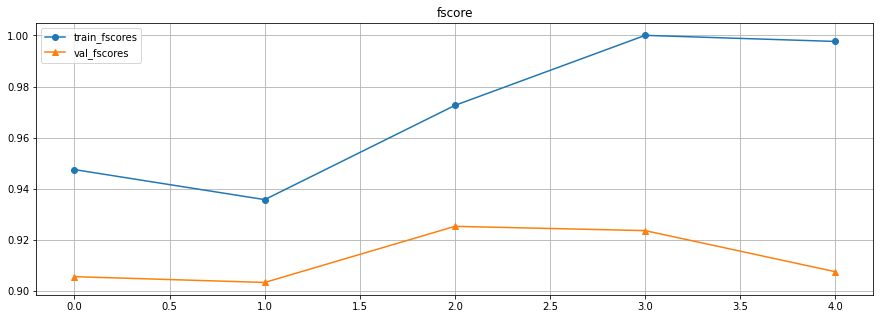

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.plot(train_fscores, '-o', label='train_fscores')
plt.plot(val_fscores, '-^', label='val_fscores')
plt.title('fscore')
plt.legend()
plt.grid()


plt.show()